# Which tree species should the city plant?

## 📖 Background
You work for a nonprofit organization advising the planning department on ways to improve the quantity and quality of trees in New York City. The urban design team believes tree size (using trunk diameter as a proxy for size) and health are the most desirable characteristics of city trees.

The city would like to learn more about which tree species are the best choice to plant on the streets of Manhattan.

In [34]:
# load packages
suppressPackageStartupMessages(library(tidyverse))
suppressPackageStartupMessages(library(forcats))
suppressPackageStartupMessages(library(scales))
suppressPackageStartupMessages(library(sf))

# load tree data
trees <- readr::read_csv('data/trees.csv', show_col_types = FALSE)

# clean data
tree_df <- trees %>%
	drop_na() %>%
	filter(tree_dbh < 46 & str_detect(nta, "MN"))

tree_df$spc_common <- str_to_title(tree_df$spc_common)

tree_df_len <- length(tree_df$spc_common)

# What are the most common tree species in Manhattan?

In [43]:
tree_dist <- tree_df %>%
	group_by(spc_common) %>%
	summarise(n = n()) %>%
	mutate(percent = percent(n / 62413, accuracy = .1)) %>%
	arrange(desc(n)) %>%
	head(5)

tree_dist

spc_common,n,percent
<chr>,<int>,<chr>
Honeylocust,13174,21.1%
Callery Pear,7295,11.7%
Ginkgo,5858,9.4%
Pin Oak,4583,7.3%
Sophora,4453,7.1%


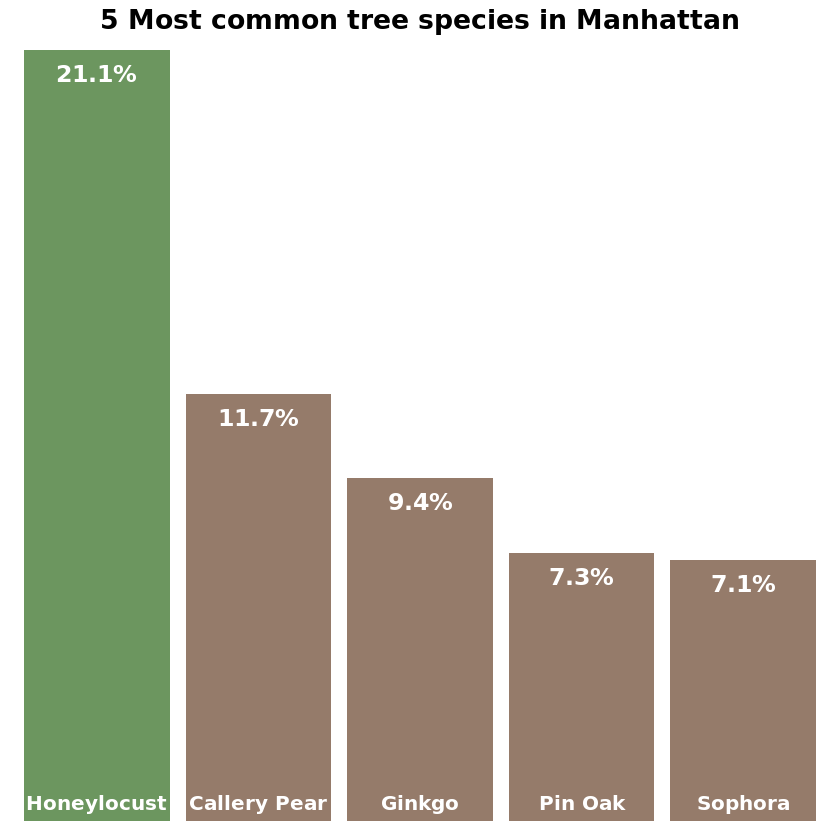

In [48]:
tree_colors <-c("#6c965f", "#957b6a", "#957b6a", "#957b6a", "#957b6a")

tree_dist %>%
	ggplot(aes(x = fct_rev(fct_reorder(spc_common,n)), y = n, fill = tree_colors)) +
	geom_col() +
	scale_fill_manual(values = tree_colors) +
	geom_text(aes(label = percent), nudge_y = -400, color = "white", fontface = "bold", size = 5, family = "NimbusRom") +
	#geom_text(aes(label = n), nudge_y = -400, color = "white", fontface = "bold", size = 5, family = "NimbusRom") +
	labs(title = "5 Most common tree species in Manhattan", x = "", y = "") +
	scale_y_continuous(limits = c(0,13200), expand = expansion(add = c(0, 250))) +
	#theme_classic() +
	theme_void() +
	theme(legend.position = "none",
          plot.title = element_text(hjust = 0.5, size = 16, face = "bold", family = "NimbusRom"),
          #axis.title.y = element_text(size = 13),
          axis.text = element_text(size = 10, face = "bold"),
          axis.text.x = element_text(size = 12, hjust = .5, vjust = 6, color = "white", angle = 0, family = "NimbusRom"),
          axis.text.y = element_blank(),
          panel.border = element_blank(),
          panel.grid = element_blank()
         )

# Which are the neighborhoods with the most trees?

In [49]:
nta_dist <- tree_df %>%
	group_by(nta_name) %>%
	summarise(n = n()) %>%
	mutate(percent = percent(n / 62413, accuracy = .1)) %>%
	arrange(desc(n)) %>%
	head(3)
	

nta_dist

nta_name,n,percent
<chr>,<int>,<chr>
Upper West Side,5723,9.2%
Upper East Side-Carnegie Hill,4538,7.3%
West Village,3715,6.0%


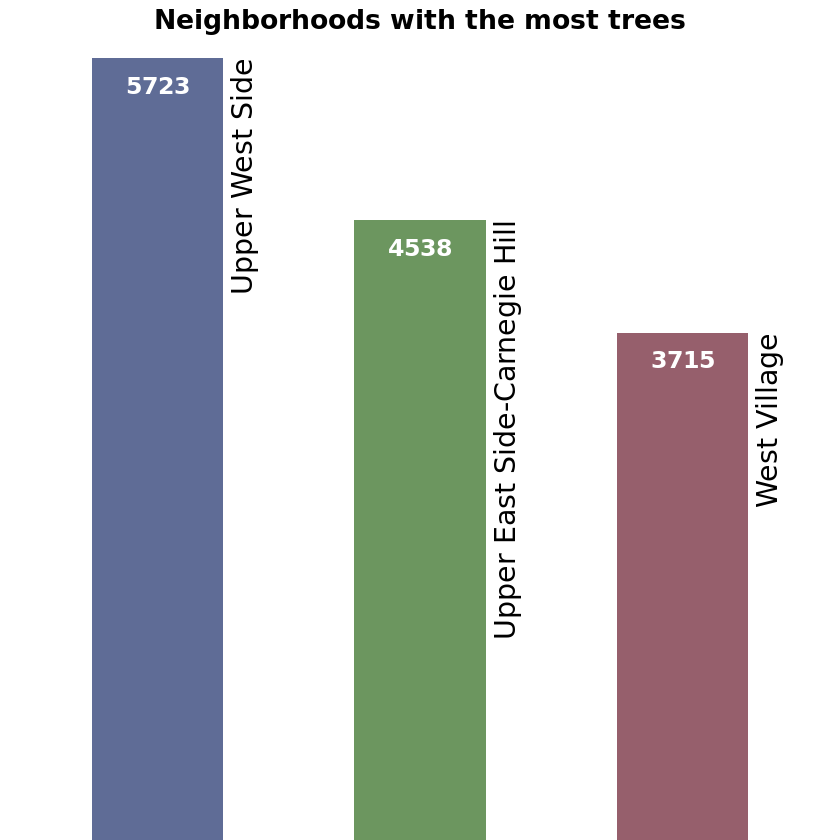

In [38]:
nta_colors <-c("#6c965f","#5f6c96","#965f6c")

nta_dist %>%
	ggplot(aes(x = fct_rev(fct_reorder(nta,n)), y = n, fill = nta_colors)) +
	geom_col(width = .5) +
	scale_fill_manual(values = nta_colors) +
	#geom_text(aes(label = percent), nudge_y = -600, color = "white", fontface = "plain", size = 4, family = "NimbusRom") +
	geom_text(aes(label = n), nudge_y = -200, color = "white", fontface = "bold", size = 5, family = "NimbusRom") +
	geom_text(aes(label = nta_name), angle = 90, nudge_x = .32, hjust = 1, size = 6, family = "NimbusRom") +
	labs(title = "Neighborhoods with the most trees", x = "", y = "") +
	scale_y_continuous(limits = c(0,5900), expand = expansion(add = c(0, 0))) +
	#theme_classic() +
	theme_void() +
	theme(legend.position = "none",
          plot.title = element_text(hjust = 0.5, size = 16, face = "bold", family = "NimbusRom"),
          #axis.title.y = element_text(size = 13),
          #axis.text = element_text(size = 10, face = "bold"),
          #axis.text.x = element_text(size = 12, hjust = .5, vjust = 6, color = "white", angle = 0, family = "NimbusRom"),
          axis.title.x = element_blank(),
          axis.text.y = element_blank(),
          panel.border = element_blank(),
          panel.grid = element_blank()
         )

# A visualization of Manhattan's neighborhoods and tree locations.

Joining, by = "nta"
Warning message in st_point_on_surface.sfc(sf::st_zm(x)):
“st_point_on_surface may not give correct results for longitude/latitude data”


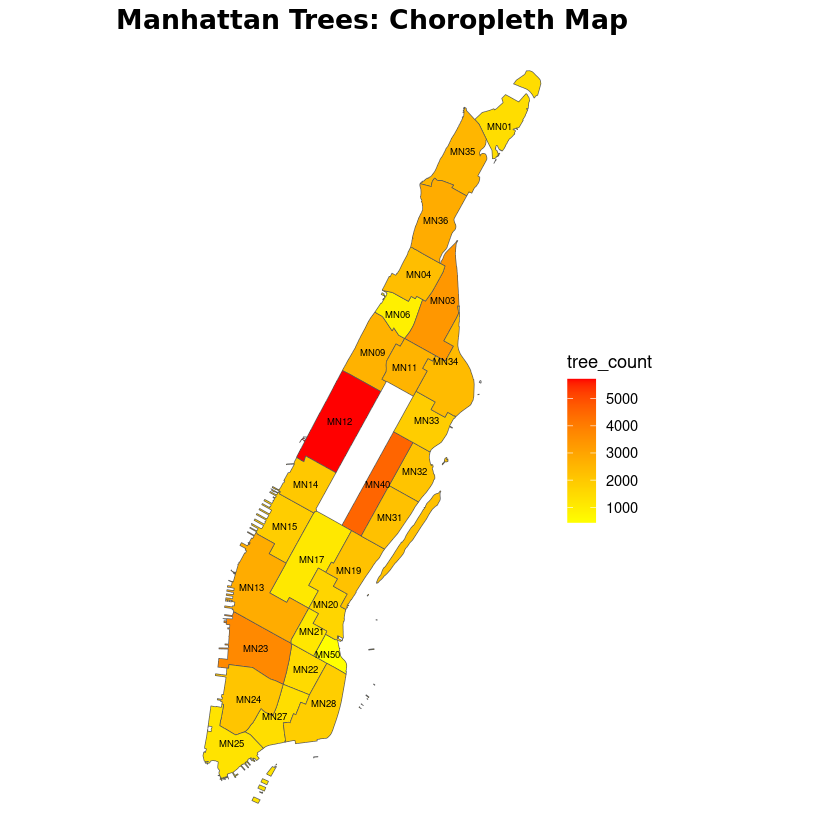

In [44]:
neighborhoods <- st_read("data/nta.shp", quiet=TRUE)

neighborhoods <- neighborhoods %>%
	filter(boroname == "Manhattan")

neighborhoods <- neighborhoods %>%
	mutate(nta = ntacode)

neighborhoods <- neighborhoods %>%
	select(-borocode, -countyfips, -ntacode)

#plot(neighborhoods["boroname"], key.pos=NULL, main = NULL)

nta_summ <- tree_df %>%
	group_by(nta) %>%
	summarise(tree_count = n())

joined_df <- neighborhoods %>%
	inner_join(nta_summ)

ggplot(data = joined_df) +
	geom_sf(aes(fill = tree_count)) +
  	scale_fill_gradient(low = "yellow", high = "red", na.value = NA) +
	geom_sf_text(aes(label = nta), colour = "black", size = 2) +
	theme_void() +
	labs(title = "Manhattan Trees: Choropleth Map") +
	theme(plot.title = element_text(hjust = 0.5, size = 16, face = "bold", family = "NimbusRom"))

# What ten tree species would you recommend the city plant in the future?
> My methods for approaching this:
1. Identify significance in the health category and trunk diameter (ANOVA)  
2. Filter trees for "Good" health  
3. Group trees by species  
4. Filter out species with 100 or less observations (n)  
5. Create mean and median columns  
6. Sort the tree species descending by median and mean (median for better accuracy)  
7. Get the top 10 entries and verify accuracy  

## Health ~ Trunk Diameter ANOVA
> ~~Null Hypothesis: **No difference among the health categories in average trunk diameter**~~
<br>

> Alternative Hypothesis: **Real difference in average trunk diameter among the health categories**  
> *P < .05*

               Df  Sum Sq Mean Sq F value Pr(>F)    
health          2   22700   11350   413.9 <2e-16 ***
Residuals   62410 1711362      27                   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

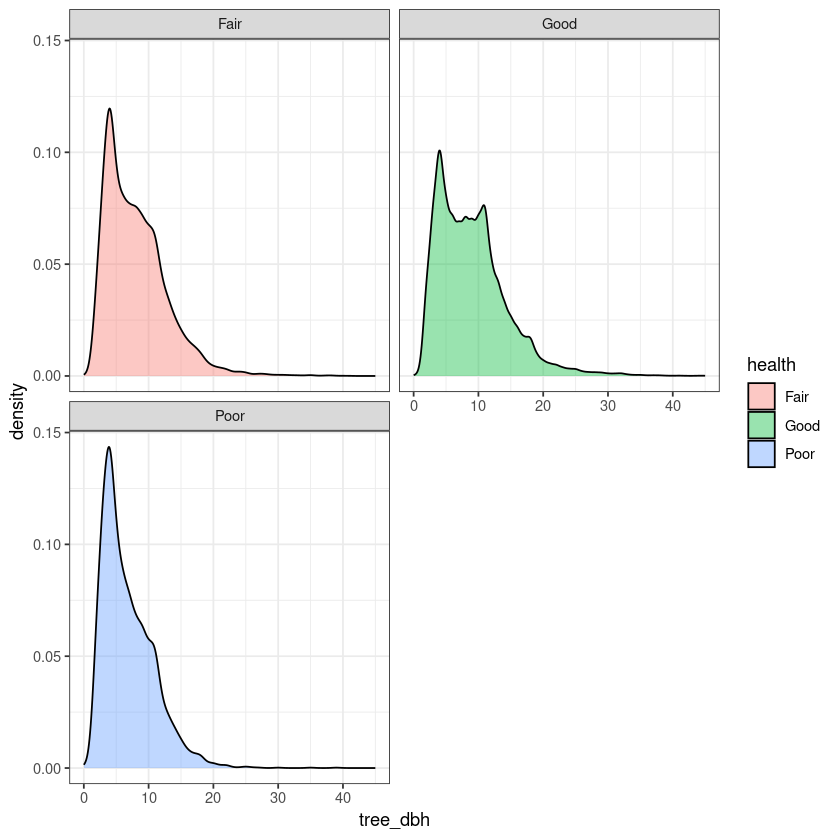

In [40]:
tree_df %>%
	ggplot(aes(x = tree_dbh, y = after_stat(density), fill = health)) +
	geom_density(alpha = .4) +
	facet_wrap(~health, nrow = 2) +
	theme_bw()

tree_df %>%
	aov(tree_dbh ~ health, data = .) %>%
	summary()

## My tree species recommendations for the city...

In [46]:
trees_to_plant <- tree_df %>%
	filter(health == "Good") %>%
	group_by(spc_common) %>%
	summarise(average = round(mean(tree_dbh),2), median = median(tree_dbh), n = n()) %>%
	arrange(desc(median), desc(average)) %>%
	filter(n > 100) %>%
	head(10)


trees_to_plant

spc_common,average,median,n
<chr>,<dbl>,<dbl>,<int>
London Planetree,14.32,14,2596
American Elm,14.55,12,1357
Siberian Elm,12.27,12,131
Willow Oak,10.96,11,745
Norway Maple,11.19,10,157
Black Locust,9.84,10,201
Pin Oak,10.51,9,3730
Green Ash,9.75,9,575
Sophora,9.39,9,3554
